In [23]:
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans

import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
pio.templates.default = 'plotly_white'
pio.renderers.default = 'png'
px.defaults.width = 1500
px.defaults.height = 500

# Data - Setup

In [2]:
ll = pd.read_csv('../data/data1.csv')
ll = ll.set_index('Date')

ll = -100*(np.log(ll)-np.log(ll.shift(1)))
ll = ll.iloc[1:]

ll = ll.rename_axis('Loss', axis=1)
ll.columns = [x[4:] for x in ll.columns]

In [13]:
# Standardize marginals
z = ll.apply(lambda x: 1/(1-x.rank()/(len(x)+1)), axis=0)

# Angular measure
r = z.apply(lambda x: np.linalg.norm(x,2), axis=1)
w = z.div(r, axis=0)

In [52]:
# Threshold
r0 = np.quantile(r,0.9)

# K-Means Clustering
## Optimal k

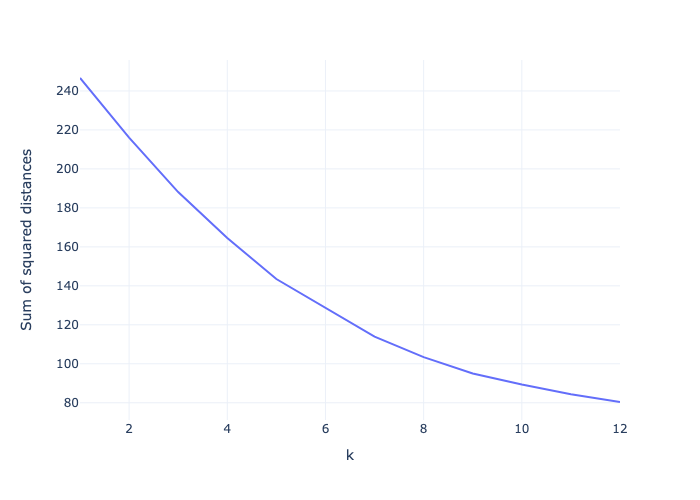

In [95]:
sum_of_squared_distances = []
K = range(1,13)
for k in K:
    km = KMeans(n_clusters=k, random_state=0).fit(w[r>r0])
    sum_of_squared_distances.append(km.inertia_)
    
px.line(x=K, y=sum_of_squared_distances).update_layout(xaxis_title='k', yaxis_title='Sum of squared distances', width=700)

## n_clusters=7

In [59]:
kmeans = KMeans(n_clusters=7, random_state=0).fit(w[r>r0])

centers = pd.DataFrame(kmeans.cluster_centers_, index=['C'+str(i) for i in range(1,8)], columns=ll.columns)

labels = pd.Series(kmeans.labels_+1, index=w[r>r0].index).apply(lambda x: 'C'+str(x))

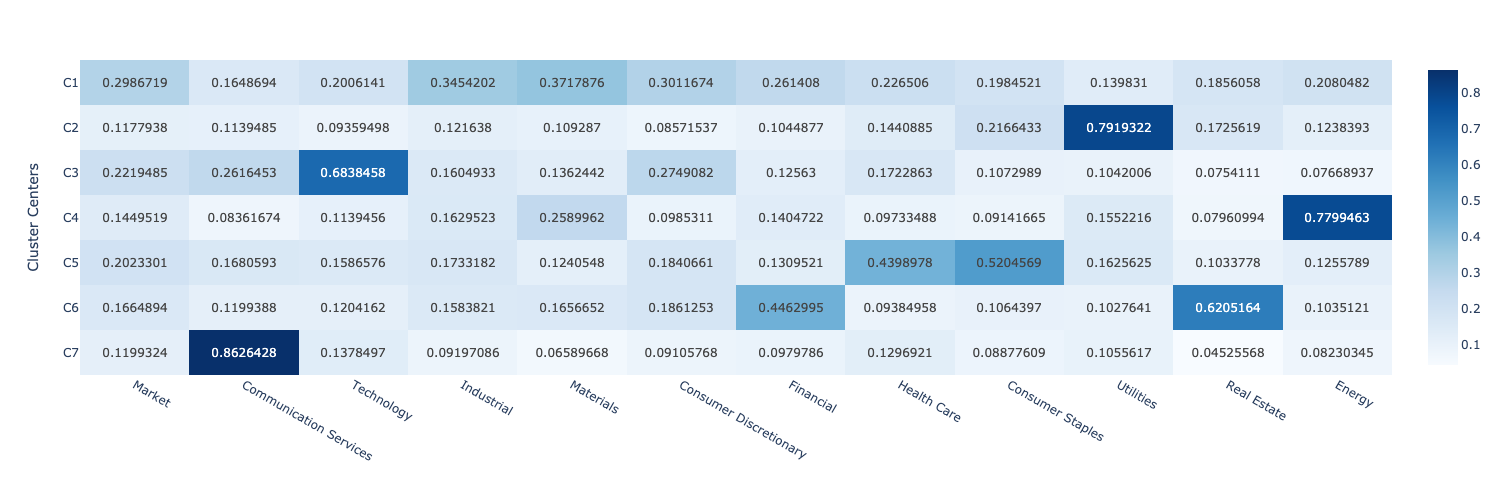

In [47]:
fig = px.imshow(centers, color_continuous_scale='Blues', text_auto=True, aspect='auto')
fig.update_layout(
    xaxis_title='', yaxis_title='Cluster Centers'
)

#fig.write_image('../figures/x.jpeg', scale=2)
fig.show()

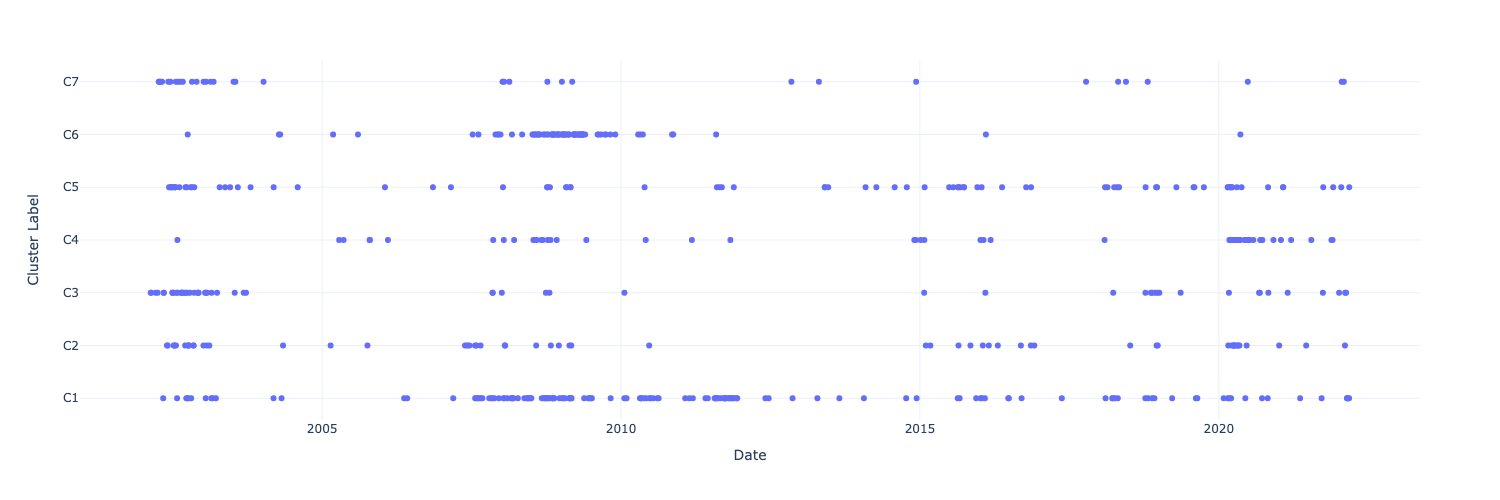

In [63]:
fig = px.scatter(labels)
fig.update_layout(
    showlegend=False, xaxis_title='Date', yaxis_title='Cluster Label'
)
fig.update_yaxes(categoryorder='array', categoryarray=centers.index)

#fig.write_image('../figures/x.jpeg', scale=2)
fig.show()

## n_clusters=7, start=chi_network

In [85]:
centers_init = np.array([
    [0.2,0,0,0.2,0.2,0.2,0.2,0,0,0,0,0],
    [0,0,0,0,0,0,0,0.5,0.5,0,0,0],
    [0,1,0,0,0,0,0,0,0,0,0,0],
    [1,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,1,0,0],
    [0,0,0,0,0,0,0,0,0,0,1,0],
    [0,0,0,0,0,0,0,0,0,0,0,1]
])

kmeans = KMeans(n_clusters=7, init=centers_init, n_init=1, random_state=0).fit(w[r>r0])

centers = pd.DataFrame(kmeans.cluster_centers_, index=['C'+str(i) for i in range(1,8)], columns=ll.columns)

labels = pd.Series(kmeans.labels_+1, index=w[r>r0].index).apply(lambda x: 'C'+str(x))

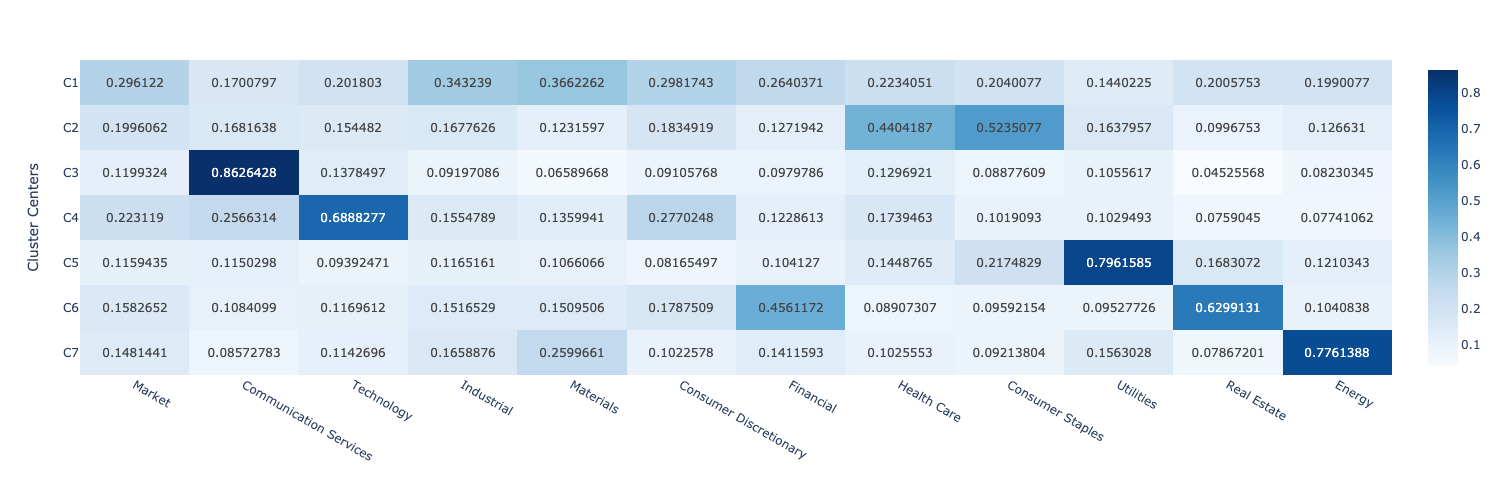

In [86]:
fig = px.imshow(centers, color_continuous_scale='Blues', text_auto=True, aspect='auto')
fig.update_layout(
    xaxis_title='', yaxis_title='Cluster Centers'
)

#fig.write_image('../figures/x.jpeg', scale=2)
fig.show()

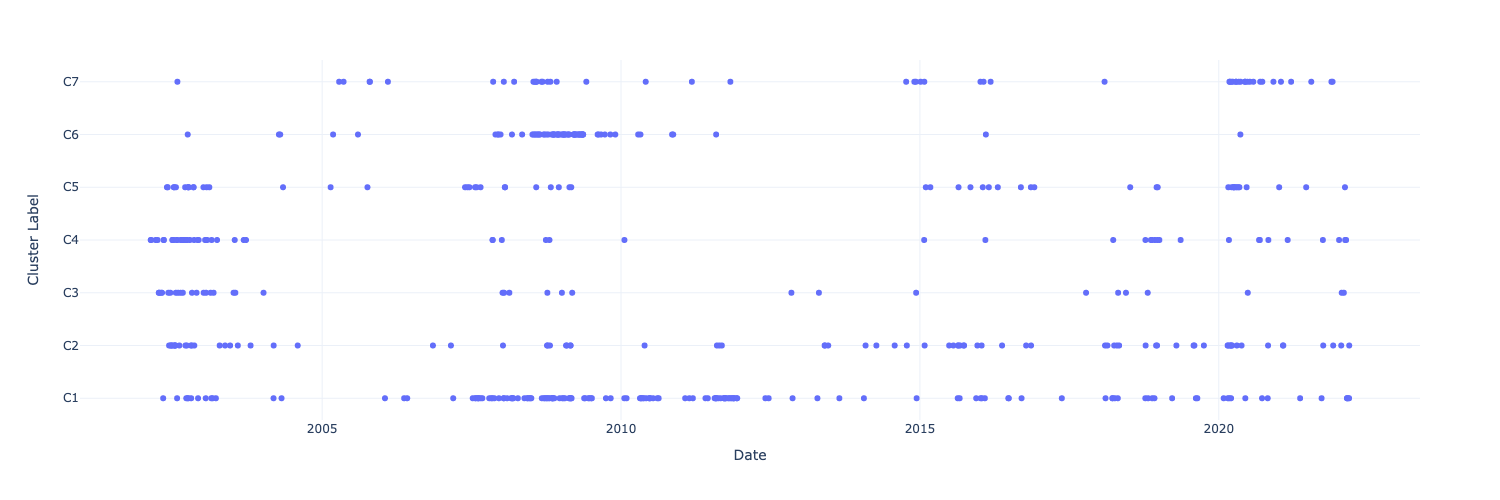

In [87]:
fig = px.scatter(labels)
fig.update_layout(
    showlegend=False, xaxis_title='Date', yaxis_title='Cluster Label'
)
fig.update_yaxes(categoryorder='array', categoryarray=centers.index)

#fig.write_image('../figures/x.jpeg', scale=2)
fig.show()

In [96]:
from sklearn.cluster import SpectralClustering